In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE



import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

## DataFrame erstellen

In [126]:
import chromadb
import pandas as pd

client = chromadb.PersistentClient(path="../VektorDB2")
collection = client.get_collection("VektorDB2")
data = collection.get(include=["embeddings", "metadatas", "documents"])

#.
df2 = pd.DataFrame({
    'id': data['ids'],
    'text': data['documents'],
    'embedding': [list(emb) for emb in data['embeddings']],
    

    'gesetz': [m.get('gesetz') or m.get('law') or 'Unbekannt' for m in data['metadatas']],
    
    'label': [m.get('label', '') for m in data['metadatas']],
    'paragraph': [m.get('paragraph', '') for m in data['metadatas']]
})
df2.head()


,id,text,embedding,gesetz,label,paragraph
0,AGG_0,AGG Präambel/Allgemein: Allgemeines Gleichbeha...,"[0.014303729869425297, -0.09027136117219925, 0...",AGG,AGG Präambel/Allgemein,Präambel/Allgemein
1,AGG_1,AGG Präambel/Allgemein: Benachteiligungen aus ...,"[-0.05146289989352226, -0.034151870757341385, ...",AGG,AGG Präambel/Allgemein,Präambel/Allgemein
2,AGG_2,AGG § 1 (Teil 1): genannten Grund sind nach Ma...,"[-0.02275240048766136, -0.03822503983974457, -...",AGG,AGG § 1 (Teil 1),§ 1
3,AGG_3,AGG § 1 (Teil 2): eßlich der Inanspruchnahme d...,"[-0.040936581790447235, 0.03495335951447487, 0...",AGG,AGG § 1 (Teil 2),§ 1
4,AGG_4,AGG § 1: Für Leistungen nach dem Sozialgesetzb...,"[-0.0775250792503357, 0.08246596157550812, 0.0...",AGG,AGG § 1,§ 1


In [127]:
print(df2['gesetz'].value_counts().head()) 

gesetz
BetrVG    654
AGG       174
ArbzG     173
MiLoG     137
KSchG     123
Name: count, dtype: int64


In [128]:
df2.isnull().sum()

id           0
text         0
embedding    0
gesetz       0
label        0
paragraph    0
dtype: int64

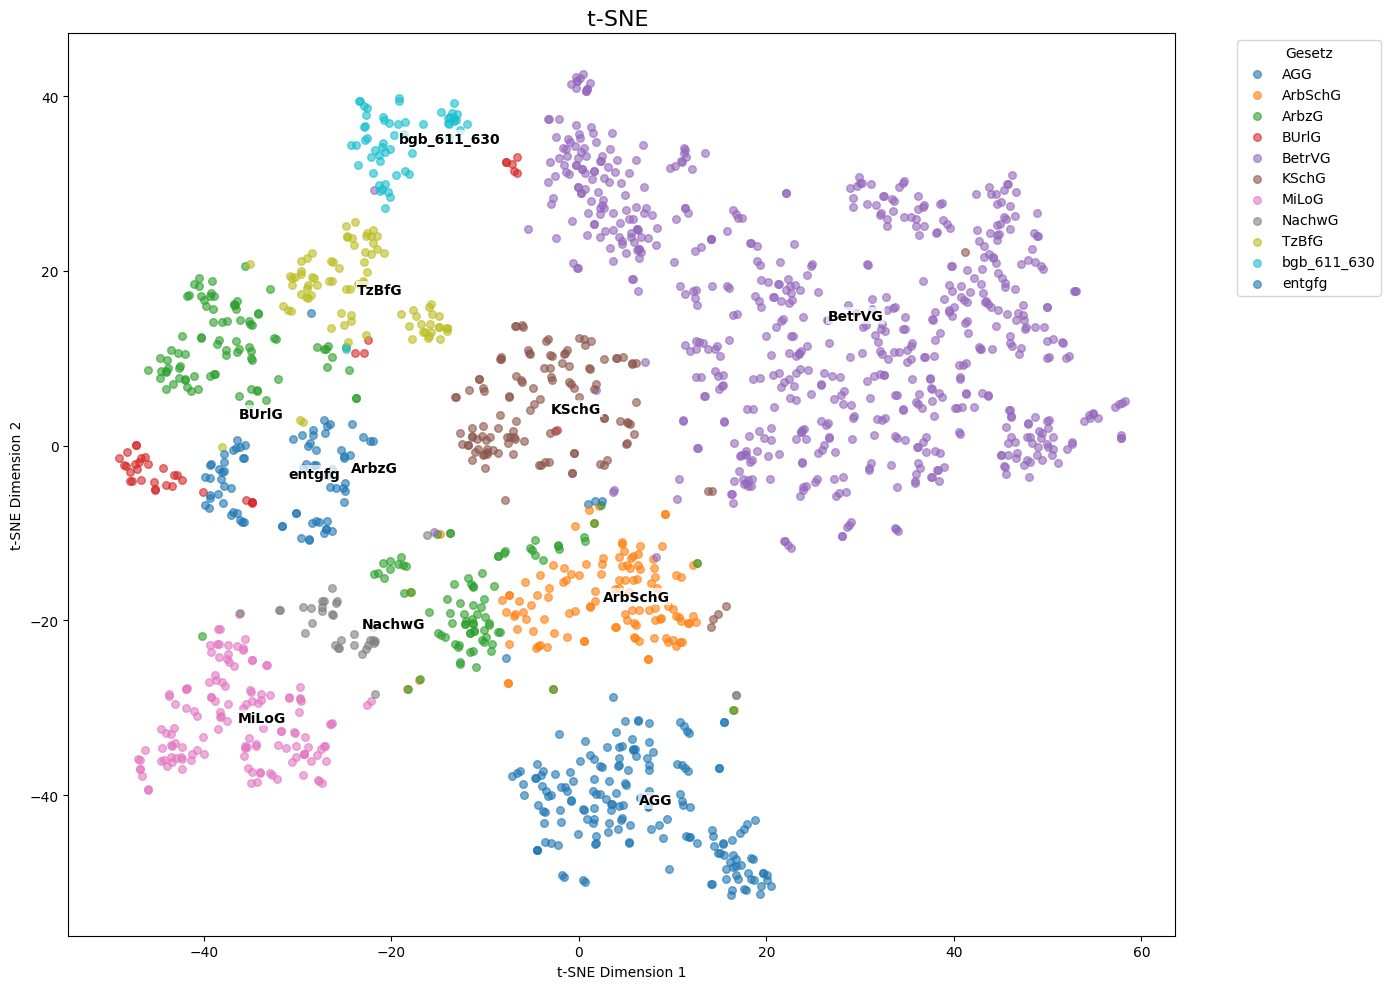

In [139]:


# 1. Daten vorbereiten 
embeddings_matrix = np.array(df2['embedding'].tolist())

# 2. t-SNE berechnen
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_matrix)

df2['tsne_x'] = embeddings_2d[:, 0]
df2['tsne_y'] = embeddings_2d[:, 1]

# 3. Visualisierung
plt.figure(figsize=(14, 10))

groups = df2.groupby('gesetz')

for name, group in groups:
    plt.scatter(group['tsne_x'], group['tsne_y'], 
                label=name,       
                alpha=0.6, 
                s=30)             

#  im mean beschriften
for name, group in groups:
    # Berechne die Mitte der Wolke
    center_x = group['tsne_x'].mean()
    center_y = group['tsne_y'].mean()
    
    plt.text(center_x, center_y, 
             name, 
             fontsize=10, 
             fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.title('t-SNE ', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.legend(title="Gesetz", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

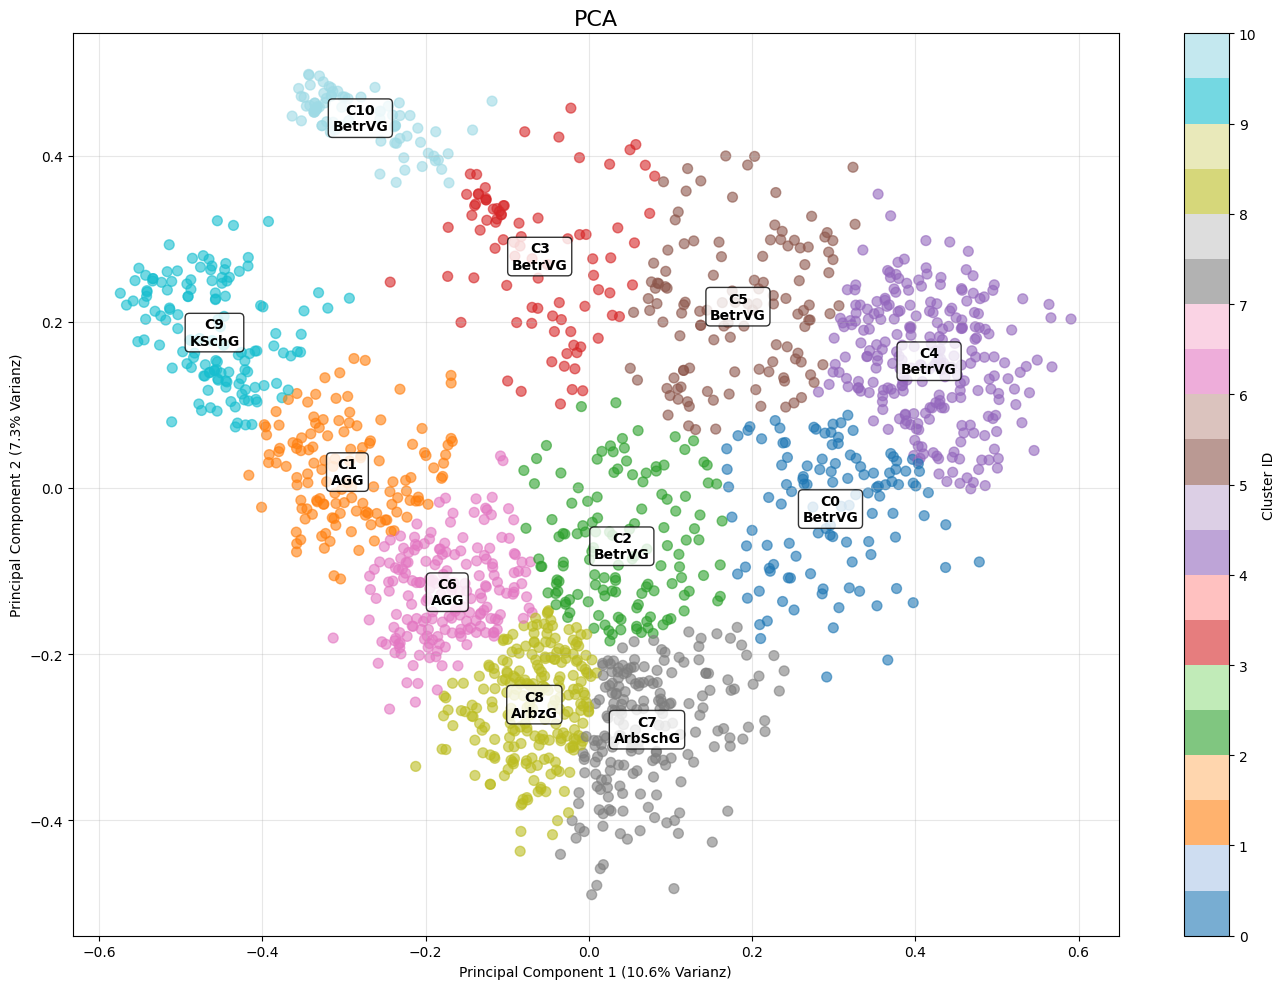


--- Analyse der PCA-Cluster Reinheit ---
PCA-Cluster 0: Dominant 'BetrVG' (78.3%)
PCA-Cluster 1: Dominant 'AGG' (25.7%)
PCA-Cluster 2: Dominant 'BetrVG' (22.6%)
PCA-Cluster 3: Dominant 'BetrVG' (97.7%)
PCA-Cluster 4: Dominant 'BetrVG' (100.0%)
PCA-Cluster 5: Dominant 'BetrVG' (98.4%)
PCA-Cluster 6: Dominant 'AGG' (21.2%)
PCA-Cluster 7: Dominant 'ArbSchG' (22.5%)
PCA-Cluster 8: Dominant 'ArbzG' (25.0%)
PCA-Cluster 9: Dominant 'KSchG' (21.9%)
PCA-Cluster 10: Dominant 'BetrVG' (100.0%)


In [130]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



#PCA durchführen 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_matrix)

# Die Koordinaten im DataFrame speichern
df2['pca_x'] = pca_result[:, 0]
df2['pca_y'] = pca_result[:, 1]

# 2. K-Means AUF DEN PCA-DATEN rechnen
# Das ist "K-Means nach PCA". Wir clustern die 2D-Punkte.
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df2['cluster_pca'] = kmeans.fit_predict(pca_result)

# 3. Visualisierung
plt.figure(figsize=(14, 10))

# Scatter Plot: Farbe = Cluster (was der Algorithmus gefunden hat)
# Wir nutzen PC1 und PC2 als Achsen
scatter = plt.scatter(df2['pca_x'], df2['pca_y'], 
                      c=df2['cluster_pca'], 
                      cmap='tab20', 
                      alpha=0.6, 
                      s=50)

# 4. Feature: Automatische Beschriftung der Cluster-Zentren mit dem häufigsten Gesetz
# Wir nutzen die Cluster-IDs aus dem PCA-K-Means
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_pca'] == i]
    
    if len(cluster_data) == 0:
        continue
        
    # a) Berechne den Mittelpunkt (Schwerpunkt) im PCA-Raum
    center_x = cluster_data['pca_x'].mean()
    center_y = cluster_data['pca_y'].mean()
    
    # b) Finde das dominanteste Gesetz in diesem Cluster (Ground Truth Check)
    top_law = cluster_data['gesetz'].value_counts().idxmax()
    
    # Label erstellen
    label_text = f"C{i}\n{top_law}"
    
    # c) Text zeichnen
    plt.text(center_x, center_y, 
             label_text, 
             fontsize=10, 
             fontweight='bold', 
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# Achsenbeschriftung und Titel
# Wichtig: Bei PCA sagt man "Principal Component 1" (erklärt am meisten Varianz)
var_explained = pca.explained_variance_ratio_
plt.title(f'PCA', fontsize=16)
plt.xlabel(f'Principal Component 1 ({var_explained[0]:.1%} Varianz)')
plt.ylabel(f'Principal Component 2 ({var_explained[1]:.1%} Varianz)')

plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster ID')
plt.grid(True, alpha=0.3) # Gitter hilft bei PCA oft zur Orientierung
plt.tight_layout()
plt.show()

# 5. Statistik: Wie sauber sind die PCA-Cluster?
print("\n--- Analyse der PCA-Cluster Reinheit ---")
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_pca'] == i]
    if len(cluster_data) == 0: continue
    
    top_law_stats = cluster_data['gesetz'].value_counts()
    dominant_law = top_law_stats.index[0]
    percentage = (top_law_stats.iloc[0] / len(cluster_data)) * 100
    
    print(f"PCA-Cluster {i}: Dominant '{dominant_law}' ({percentage:.1f}%)")

In [131]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


/Users/perezopoku/Desktop/Programme/Persönlcihe Projekte/RAG/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


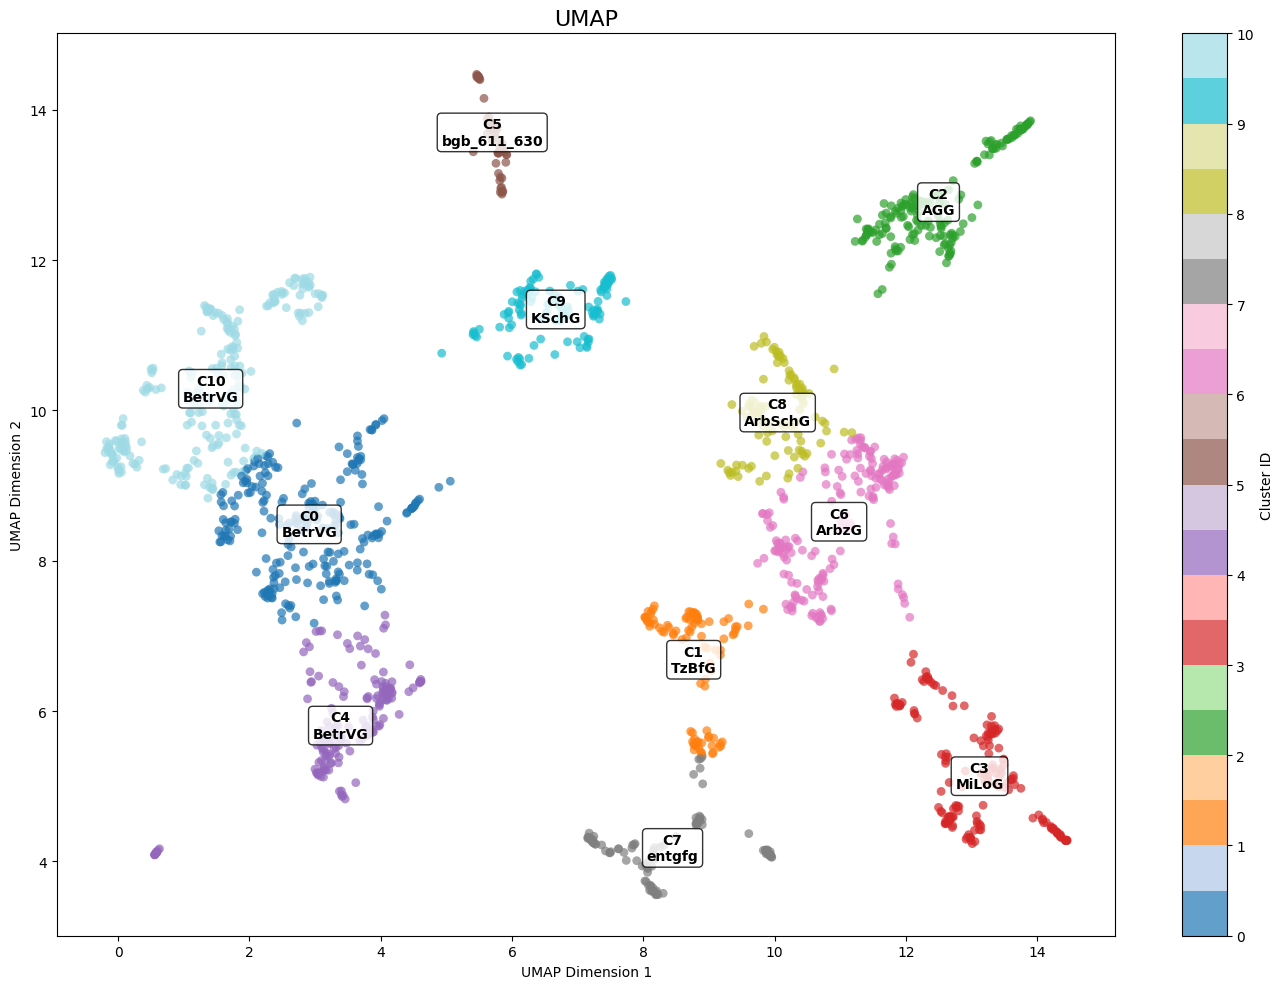


--- Analyse der UMAP-Cluster Reinheit ---
UMAP-Cluster 0: Dominant 'BetrVG' (99.2%)
UMAP-Cluster 1: Dominant 'TzBfG' (60.2%)
UMAP-Cluster 2: Dominant 'AGG' (98.8%)
UMAP-Cluster 3: Dominant 'MiLoG' (80.6%)
UMAP-Cluster 4: Dominant 'BetrVG' (95.3%)
UMAP-Cluster 5: Dominant 'bgb_611_630' (98.3%)
UMAP-Cluster 6: Dominant 'ArbzG' (82.2%)
UMAP-Cluster 7: Dominant 'entgfg' (49.5%)
UMAP-Cluster 8: Dominant 'ArbSchG' (80.4%)
UMAP-Cluster 9: Dominant 'KSchG' (98.3%)
UMAP-Cluster 10: Dominant 'BetrVG' (99.6%)


In [132]:
import umap.umap_ as umap  # pip install umap-learn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. UMAP Reduktion durchführen (auf 2 Dimensionen)
# n_neighbors: Balance zwischen lokaler und globaler Struktur (15-50 ist gut)
# min_dist: Wie eng dürfen Punkte zusammenrücken (0.1 ist standard)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = reducer.fit_transform(embeddings_matrix)

# Koordinaten speichern
df2['umap_x'] = umap_result[:, 0]
df2['umap_y'] = umap_result[:, 1]

# 2. K-Means auf den UMAP-Koordinaten rechnen
# Wir clustern direkt die 2D-Projektion, damit die Farben perfekt zu den Inseln passen
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df2['cluster_umap'] = kmeans.fit_predict(umap_result)

# 3. Visualisierung
plt.figure(figsize=(14, 10))

# Scatter Plot
scatter = plt.scatter(df2['umap_x'], df2['umap_y'], 
                      c=df2['cluster_umap'], 
                      cmap='tab20', # Große Farbpalette für 11 Cluster
                      alpha=0.7, 
                      s=40,
                      edgecolors='none')

# 4. Feature: Automatische Beschriftung der Cluster-Zentren (Dominantes Gesetz)
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_umap'] == i]
    
    if len(cluster_data) == 0:
        continue
        
    # Schwerpunkt im UMAP-Raum berechnen
    center_x = cluster_data['umap_x'].mean()
    center_y = cluster_data['umap_y'].mean()
    
    # Häufigstes Gesetz in diesem Cluster finden
    top_law_stats = cluster_data['gesetz'].value_counts()
    top_law = top_law_stats.idxmax()
    count = top_law_stats.iloc[0]
    
    # Label erstellen (z.B. "KSchG")
    label_text = f"C{i}\n{top_law}"
    
    # Text zeichnen (mit weißer Box für Lesbarkeit)
    plt.text(center_x, center_y, 
             label_text, 
             fontsize=10, 
             fontweight='bold', 
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# Titel und Achsen
plt.title('UMAP', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster ID')
plt.tight_layout()
plt.show()

# 5. Statistik: Wie rein sind die UMAP-Inseln?
print("\n--- Analyse der UMAP-Cluster Reinheit ---")
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_umap'] == i]
    if len(cluster_data) == 0: continue
    
    top_law_stats = cluster_data['gesetz'].value_counts()
    dominant_law = top_law_stats.index[0]
    percentage = (top_law_stats.iloc[0] / len(cluster_data)) * 100
    
    print(f"UMAP-Cluster {i}: Dominant '{dominant_law}' ({percentage:.1f}%)")

/Users/perezopoku/Desktop/Programme/Persönlcihe Projekte/RAG/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


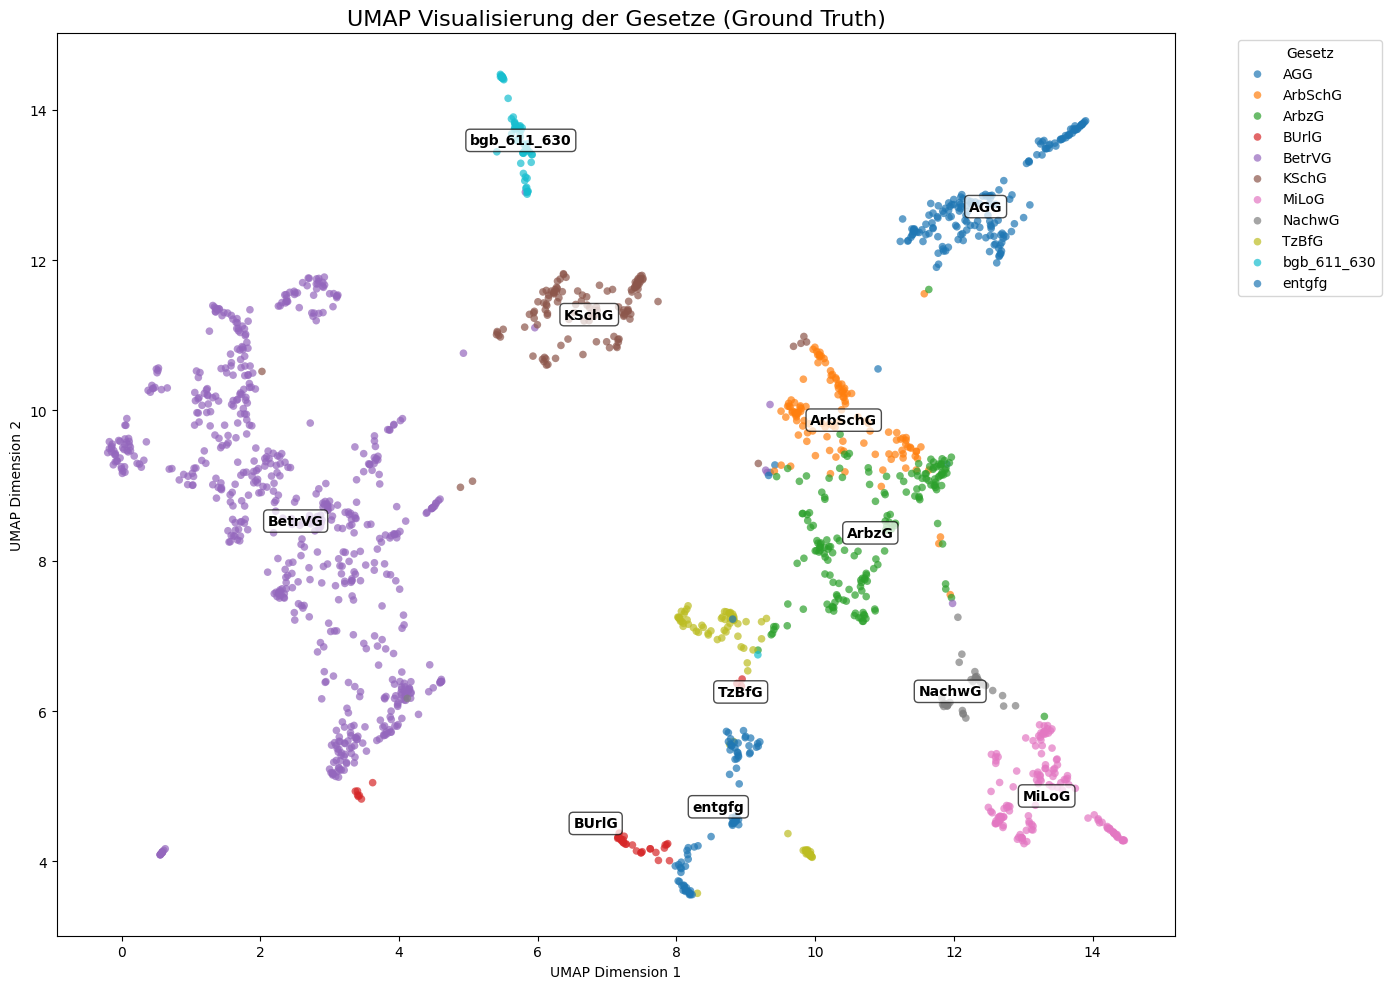

In [142]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#UMAP 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = reducer.fit_transform(embeddings_matrix)

df2['umap_x'] = umap_result[:, 0]
df2['umap_y'] = umap_result[:, 1]

# 2. Visualisierung (Direkt nach Gesetz gruppieren)
plt.figure(figsize=(14, 10))

# Wir gruppieren den DataFrame nach der Spalte 'gesetz'
groups = df2.groupby('gesetz')

# Loop durch jede Gruppe (jedes Gesetz), um es zu plotten
for name, group in groups:
    plt.scatter(group['umap_x'], group['umap_y'], 
                label=name,       
                alpha=0.7, 
                s=30,
                edgecolors='none') # Ränder weg für saubereren Look

e
for name, group in groups:
    # Schwerpunkt im UMAP-Raum berechnen
    center_x = group['umap_x'].mean()
    center_y = group['umap_y'].mean()
    
    # Text zeichnen
    plt.text(center_x, center_y, 
             name, 
             fontsize=10, 
             fontweight='bold', 
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

# Titel und Achsen
plt.title('UMAP Visualisierung)', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title="Gesetz", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Zeigen das PCA nicht funktioniert, weil Strukturen nicht linear sind

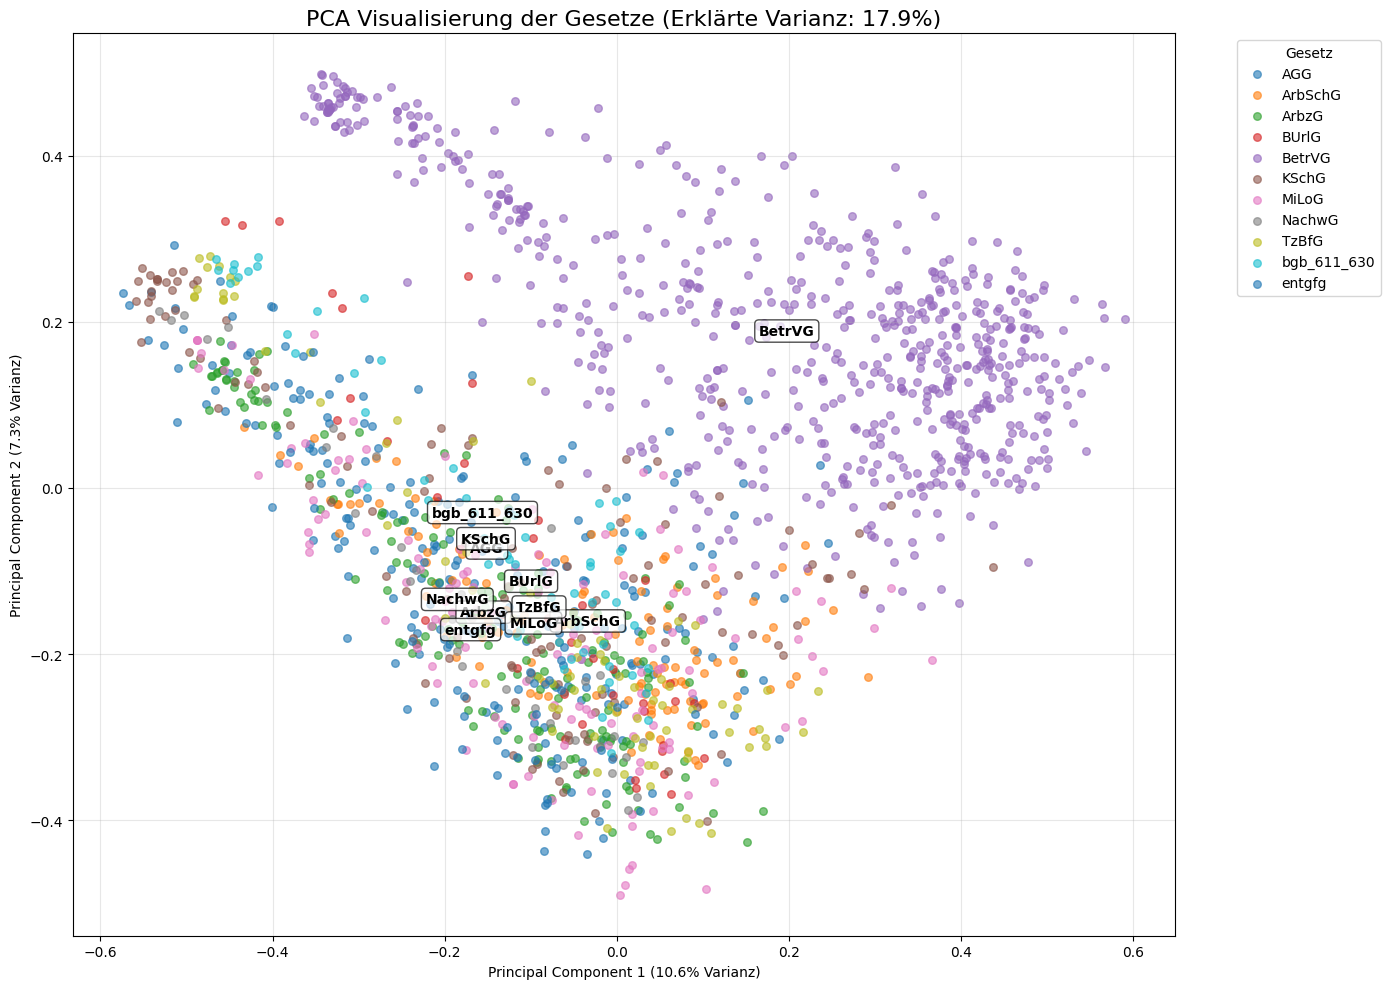

In [143]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. PCA durchführen (Reduktion auf 2 Dimensionen)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_matrix)

# Koordinaten speichern
df2['pca_x'] = pca_result[:, 0]
df2['pca_y'] = pca_result[:, 1]

# 2. Visualisierung (Direkt nach Gesetz gruppieren, kein K-Means!)
plt.figure(figsize=(14, 10))

# Wir gruppieren nach dem ECHTEN Label 'gesetz'
groups = df2.groupby('gesetz')

# Für jedes Gesetz die Punkte malen
for name, group in groups:
    plt.scatter(group['pca_x'], group['pca_y'], 
                label=name,       
                alpha=0.6, 
                s=30)

# 3. Beschriftung der Zentren (Wo liegt der Schwerpunkt des Gesetzes?)
for name, group in groups:
    # Berechne den Mittelpunkt (Schwerpunkt) der Wolke dieses Gesetzes
    center_x = group['pca_x'].mean()
    center_y = group['pca_y'].mean()
    
    # Label zeichnen
    plt.text(center_x, center_y, 
             name, 
             fontsize=10, 
             fontweight='bold', 
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

# Achsenbeschriftung und Titel
# Die erklärte Varianz ist bei PCA eine der wichtigsten Infos!
var_explained = pca.explained_variance_ratio_
total_var = sum(var_explained) * 100

plt.title(f'PCA (ungeeignet aufgrund nichtlinearer Struktur)")', fontsize=16)
plt.xlabel(f'Principal Component 1 ({var_explained[0]:.1%} Varianz)')
plt.ylabel(f'Principal Component 2 ({var_explained[1]:.1%} Varianz)')

# Legende hinzufügen (optional, kann bei vielen Gesetzen voll werden)
plt.legend(title="Gesetz", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [133]:
from dotenv import load_dotenv, dotenv_values
import os

load_dotenv("../key.env")
jinaai_api_key = os.getenv("JINAAI_API_KEY")

#print(os.getenv("JINAAI_API_KEY"))

In [134]:
from llama_index.embeddings.jinaai import JinaEmbedding
import pandas as pd
import chromadb

# 2. Embedding-Modell für die SUCHE initialisieren
# WICHTIG: task="retrieval.query" (nicht passage!)
query_embed_model = JinaEmbedding(
    api_key=jinaai_api_key,
    model="jina-embeddings-v3",
    task="retrieval.query" 
)



# --- TEST ---
# Beispiel 1: Urlaub


In [135]:
query_embed_model = JinaEmbedding(
    api_key=jinaai_api_key,
    model="jina-embeddings-v3",
    task="retrieval.query" 
)





In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Wir nutzen das Model, das du schon definiert hast (task="retrieval.query")
# query_embed_model = ... (Dein Code von oben)

def search_law(query_text, top_k=5):
    """
    Sucht die 5 ähnlichsten Gesetzes-Chunks zu einer Frage oder einem Text.
    Gibt einen DataFrame und die Vektoren zurück.
    """
    # 1. Query in Vektor umwandeln
    query_vector = query_embed_model.get_text_embedding(query_text)
    
    # 2. Suche in Chroma
    results = collection.query(
        query_embeddings=[query_vector],
        n_results=top_k,
        include=["metadatas", "documents", "distances"]
    )
    
    hits = []
    # Chroma gibt Listen in Listen zurück (Batch-Format)
    for i in range(len(results['ids'][0])):
        
        # WICHTIG: Cosine Distance in Similarity umrechnen
        # Distance 0.1 => Similarity 0.9 (90%)
        dist = results['distances'][0][i]
        sim = 1 - dist
        
        meta = results['metadatas'][0][i]
        
        hits.append({
            'Score': sim,  # Zum Sortieren
            'Match': f"{sim:.1%}", # Für die Anzeige (z.B. 85.3%)
            'Gesetz': meta.get('gesetz', '?'),
            'Label': meta.get('label', 'Kein Label'),
            'Text': results['documents'][0][i]
        })
    
    return pd.DataFrame(hits)

print("Such-Funktion bereit!")

Such-Funktion bereit!


In [137]:
from pprint import pprint
# Beispiel-Frage
frage = "Wie viel Urlaubstage habe ich mindestens?"

df_result = search_law(frage, top_k=3)

print(f"Frage: {frage}\n")
# Wir zeigen nur die relevanten Spalten
pprint(df_result[['Match', 'Label', 'Text']].to_string(index=False))

Frage: Wie viel Urlaubstage habe ich mindestens?

('Match      '
 'Label                                                                                                                                                                                                                                                                                                                                                                                                                                         '
 'Text\n'
 '61.5% BUrlG § '
 '12                                                                                                                                                                                                                                                                                                                                                                              '
 'BUrlG § 12: Der Urlaub beträgt jährlich mindestens 24 Werktage.\n'
 '52.9% BUrlG § 12 BUrlG § 12: D

In [138]:
# Beispiel-Frage
frage = "Ich bin seit 2 wochen eingestellt, kriege ich geld wenn ich mich krank melde"

df_result = search_law(frage, top_k=3)

print(f"Frage: {frage}\n")
# Wir zeigen nur die relevanten Spalten
pprint(df_result[['Match', 'Label', 'Text']].to_string(index=False))

Frage: Ich bin seit 2 wochen eingestellt, kriege ich geld wenn ich mich krank melde

('Match                     '
 'Label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         '
 'Text\n'
 '36.8%                 AGG § '
 '273                                                    